# Combining the processed crop data

In [1]:
import os, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

## Combine the processed crop data and shapefile

In [2]:
# Merge crop data
country_iso_list = [
    'AF','AO','BF','BI','BJ','CD','CF','CM','ET','GN','KE','LR','LS','MG','ML','MR','MW','MZ',
    'NE','SD','SL','SN','SO','SS','TD','TG','TZ','UG','ZA','ZM','ZW','YE'
] #Not yet ready: 'NG'.
container = []
for country_iso in country_iso_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
    cols_raw = df.columns
    # Combine different products to a single product
    # *** This should be updated to not to re-caculate the yield ***
    if country_iso == 'BF':
        df['product'].replace({'Sorghum': 'Sorghum', 'Sorghum (Red)': 'Sorghum'}, inplace=True)
    if country_iso == 'BI':
        df['product'].replace({
            'Cooking Banana': 'Banana', 'Banana': 'Banana',
            'Rice':'Rice', 'Rice (not husked)': 'Rice',
        }, inplace=True)
    if country_iso == 'ET':
        df['product'].replace({'Avocado (Hass)': 'Avocado', 'Avocado (unspecified)': 'Avocado'}, inplace=True)
    if country_iso == 'ZA':
        df['product'].replace({'Maize (White)': 'Maize', 'Maize (Yellow)': 'Maize'}, inplace=True)
    if country_iso == 'AO':
        df['product'].replace({'Millet': 'Millet', 'Millet (Pearl)': 'Millet'}, inplace=True)
    if country_iso == 'LS':
        df['product'].replace({'Maize': 'Maize', 'Maize (White)': 'Maize'}, inplace=True)
    if country_iso == 'MW':
        df['product'].replace({'Millet': 'Millet', 'Millet (Finger)': 'Millet', 'Millet (Pearl)': 'Millet'}, inplace=True)
    if country_iso == 'MZ':
        df['product'].replace({
            'Sweet Potatoes': 'Sweet Potatoes',
            'Sweet Potatoes (Non-Orange)': 'Sweet Potatoes', 
            'Sweet Potatoes (Orange)': 'Sweet Potatoes',
            'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
            'Groundnuts (In Shell, Large)': 'Groundnuts (In Shell)',
            'Groundnuts (In Shell, Small)': 'Groundnuts (In Shell)',
        }, inplace=True)
    if country_iso == 'SD' or country_iso == 'SS':
        df['product'].replace({
            'Cotton': 'Cotton',
            'Cotton (Acala)': 'Cotton', 
            'Cotton (American)': 'Cotton', 
            'Cotton (Egyptian)': 'Cotton',
        }, inplace=True)
    cols = [
        'fnid', 'country', 'country_code', 'admin_1', 'admin_2', 'name',   
        'season_name', 'planting_year', 'planting_month',
        'harvest_year', 'harvest_month', 'crop_production_system',
    ]
    area = df[df['indicator'] == 'area'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    prod = df[df['indicator'] == 'production'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    crop = prod/area
    area = area.stack().rename('value').reset_index()
    area['indicator'] = 'area'
    prod = prod.stack().rename('value').reset_index()
    prod['indicator'] = 'production'
    crop = crop.stack().rename('value').reset_index()
    crop['indicator'] = 'yield'
    df = pd.concat([area, prod, crop])[cols_raw]
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)

# Manual changes -------------------------------------------- #
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# Change product name
df['product'] = df['product'].replace({
    'Sunflower seed':'Sunflower Seed',  # Zambia
    'Cowpea':'Cowpeas',                 # Burkina Faso
})
# ----------------------------------------------------------- #

# Merge the shapefiles used to process the crop data
path_dir = '../data/shapefile/fewsnet/'
shape_fn_list = []
# - Asia
shape_fn_list.append(os.path.join(path_dir, 'AF_Admin1_2017.shp')) # Afghanistan Admin1 in 2017
shape_fn_list.append(os.path.join(path_dir, 'YE_Admin1_2014.shp')) # Yemen Admin1 in 2014
# - East Africa
shape_fn_list.append(os.path.join(path_dir, 'BI_Admin1_1998.shp')) # Brundi Admin1 in 1998
shape_fn_list.append(os.path.join(path_dir, 'ET_Admin2_2019.shp')) # Ethiopia Admin2 in 2019
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2009.shp')) # Kenya Admin1 in 2009
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2013.shp')) # Kenya Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin1_1990.shp')) # Somalia Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin2_1990.shp')) # Somalia Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'MG_Admin2_2009.shp')) # Madagascar Admin2 in 2009
shape_fn_list.append(os.path.join(path_dir, 'MW_Admin2_2003.shp')) # Malawi Admin2 in 2003
shape_fn_list.append(os.path.join(path_dir, 'MZ_Admin1_2021.shp')) # Mozambique Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'RW_Admin2_2006.shp')) # Rwanda Admin2 in 2006
shape_fn_list.append(os.path.join(path_dir, 'SS_Admin2_2011.shp')) # South Sudan Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'TZ_Admin1_2012.shp')) # Tanzania Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'UG_Admin2_2007.shp')) # Uganda Admin2 in 2007
shape_fn_list.append(os.path.join(path_dir, 'ZM_Admin2_2011.shp')) # Zambia Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin1_2011.shp')) # Zimbabwe Admin1 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin2_2011.shp')) # Zimbabwe Admin2 in 2011
# - Central Africa
shape_fn_list.append(os.path.join(path_dir, 'AO_Admin1_2008.shp')) # Angola Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin1_2008.shp')) # Cameroon Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'CF_Admin1_2003.shp')) # Central African Republic Admin1 in 2003
shape_fn_list.append(os.path.join(path_dir, 'TD_Admin1_2012.shp')) # Chad Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'CD_Admin1_2015.shp')) # DRC Admin1 in 2015
# - North Africa
shape_fn_list.append(os.path.join(path_dir, 'MR_Admin1_1990.shp')) # Mauritania Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SD_Admin1_2013.shp')) # Sudan Admin1 in 2013
# - West Africa
shape_fn_list.append(os.path.join(path_dir, 'BJ_Admin2_2015.shp')) # Benin Admin2 in 2015
shape_fn_list.append(os.path.join(path_dir, 'BF_Admin2_2001.shp')) # Burkina Faso Admin2 in 2001
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin2_2008.shp')) # Cameroon Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'GN_Admin2_1990.shp')) # Guinea Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'LR_Admin1_2008.shp')) # Liberia Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'ML_Admin1_2016.shp')) # Mali Admin1 in 2016
shape_fn_list.append(os.path.join(path_dir, 'NE_Admin2_2012.shp')) # Niger Admin2 in 2012
shape_fn_list.append(os.path.join(path_dir, 'NG_Admin1_1996.shp')) # Nigeria Admin1 in 1996
shape_fn_list.append(os.path.join(path_dir, 'SN_Admin2_2008.shp')) # Senegal Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'SL_Admin2_1960.shp')) # Sierra Leone Admin2 in 1960
# - Southern Africa
shape_fn_list.append(os.path.join(path_dir, 'LS_Admin1_1980.shp')) # Lesotho Admin1 in 1980
shape_fn_list.append(os.path.join(path_dir, 'ZA_Admin1_1994.shp')) # South Africa Admin1 in 1994
# Merge the shapefiles
shape = pd.concat([gpd.read_file(fn).to_crs(epsg=4326) for fn in shape_fn_list], axis=0).reset_index(drop=True)
shape['COUNTRY_ISO'] = shape['FNID'].apply(lambda x: x[:2])
shape = shape[['FNID','COUNTRY_ISO','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values('FNID').reset_index(drop=True)
# Manual correction
# Drop a row if FNID is "ZW2011A21503" and ADMIN2 is "Hwange Urban"
shape = shape[~((shape['FNID'] == 'ZW2011A21503') & (shape['ADMIN2'] == 'Hwange Urban'))]
assert len(shape['FNID'].unique()) == shape.shape[0]
# Reduce to designated countries
if True: shape = shape[shape['COUNTRY_ISO'].isin(country_iso_list)].reset_index(drop=True)
# Create country boundary (Admin0)
admin0 = shape.copy(deep=True)
admin0['ADMIN_CODE'] = admin0['FNID'].apply(lambda x: x[:8])
admin0 = admin0.to_crs(epsg=3857)
admin0['geometry'] = admin0['geometry'].buffer(200)
admin0 = admin0.dissolve(by='ADMIN_CODE')
admin0['geometry'] = admin0['geometry'].buffer(-200)
admin0 = admin0.loc[~admin0.index.isin(['KE2009A1','SO1990A1','ZW2011A1']),:]
admin0[['ADMIN1','ADMIN2']] = ''
admin0['FNID'] = admin0.index
admin0['FNID'] = admin0['FNID'].apply(lambda x: x[:-1]+'0')
admin0 = admin0.reset_index(drop=True)
admin0 = admin0.to_crs(epsg=4326)
# Merge
shape = pd.concat([admin0, shape], ignore_index=True).reset_index(drop=True)
shape = shape[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values(by=['FNID']).reset_index(drop=True)
# Change country_name
shape['ADMIN0'] = shape['ADMIN0'].replace({'Democratic Republic of the Congo': 'DRC'})

# Unstable version ------------------------------------------ #
fn_out = '../public/hvstat_data.csv'
df.to_csv(fn_out); print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
fn_out = '../public/hvstat_shape.gpkg'
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
shape_simplified.to_file(fn_out, driver='GPKG'); print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# ----------------------------------------------------------- #

../public/hvstat_data.csv is saved (48.35 MB).
../public/hvstat_shape.gpkg is saved (10.11 MB).


## Summary of "hvstat_data.csv"

In [3]:
shape = gpd.read_file('../public/hvstat_shape.gpkg')
shape = shape[shape['FNID'].apply(lambda x: x[-2:] != 'A0')].reset_index(drop=True)
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
df = df[['fnid','country','admin1','admin2','product','season','harvest_month','harvest_year','indicator','value']]
cps = df[['country','product','season']].drop_duplicates().reset_index(drop=True)
df['admin'] = df['fnid'].apply(lambda x: x[2:8])
table = pd.DataFrame(
    index=pd.MultiIndex.from_frame(df[['country','admin','season']].drop_duplicates()),
    columns= cps['product'].unique(),
    data = '-'
).rename_axis(columns='product')
for i, (country_name, product_name, season_name) in cps.iterrows():
    fnids_country = shape.loc[shape['ADMIN0'] == country_name, 'FNID']
    sub = df[
        (df['country'] == country_name) &
        (df['product'] == product_name) &
        (df['season'] == season_name) &
        (df['indicator'] == 'production')
    ]
    if sub.shape[0] > 0:
        count = sub.pivot_table(index='harvest_year', columns='fnid', values='value', aggfunc='count', fill_value=0)
        mean_count = count.sum().mean()
        string = '%d (%d/%d)' %  (mean_count, count.shape[1], len(fnids_country))
    else:
        string = '-'
    table.loc[pd.IndexSlice[country_name,:,season_name],product_name] = string
print('Mean record years (recorded districts / total districts)')
print(table.shape)
table

/var/folders/ky/zzrsqjvn1mz27kznr_6xjwnr0000gn/T/ipykernel_6215/211419670.py:3: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../public/hvstat_data.csv', index_col=0)


Mean record years (recorded districts / total districts)
(64, 133)


product                                                    Wheat     Cassava  \
country                      admin  season                                     
Afghanistan                  2017A1 Spring            21 (33/34)           -   
                                    Winter            21 (33/34)           -   
Angola                       2008A1 Main                1 (2/18)  17 (18/18)   
Burkina Faso                 2001A2 Annual                     -           -   
                                    Main                       -           -   
Burundi                      1998A1 Season A            3 (6/17)  17 (16/17)   
                                    Season B          12 (11/17)  17 (16/17)   
                                    Season C            2 (7/17)  17 (16/17)   
Benin                        2015A2 Annual                     -  20 (34/77)   
                                    Main                       -           -   
DRC                          2015A1 Main                       -  10 (21/26)   
Central African Republic     2003A1 Main                       -   3 (16/17)   
Cameroon                     2008A2 Annual                     -   8 (56/68)   
                                    North 1st Season           -           -   
                                    North 2nd Season           -           -   
                                    1st Season                 -           -   
                                    2nd Season                 -           -   
Ethiopia                     2019A2 Meher             13 (55/84)           -   
Guinea                       1990A2 Main                       -   6 (33/34)   
Kenya                        2013A1 Annual            23 (21/55)   2 (43/55)   
                                    Long                       -           -   
                                    Short                      -           -   
Liberia                      2008A1 Main                       -   7 (15/15)   
Lesotho                      1980A1 Summer            34 (10/10)           -   
                                    Winter              7 (6/10)           -   
Madagascar                   2009A2 Annual                     -  29 (22/22)   
Mali                         2016A1 Main               18 (3/11)           -   
Mauritania                   1990A1 Annual                     -           -   
                                    Bas-fond            3 (4/13)           -   
                                    Dam retention       4 (4/13)           -   
                                    Main                       -           -   
                                    Hot off-season             -           -   
                                    Walo                       -           -   
                                    Cold off-season     6 (2/13)           -   
Malawi                       2003A2 Main                       -  30 (28/28)   
                                    Winter              2 (7/28)           -   
Mozambique                   2021A1 Annual                     -  22 (10/11)   
                                    Cotton season              -           -   
                                    Main                1 (2/11)           -   
                                    Rice season                -           -   
Niger                        2012A2 Main                       -    3 (3/74)   
Sudan                        2013A1 Main                7 (8/18)           -   
                                    Winter             24 (9/18)           -   
Sierra Leone                 1960A2 Main                       -   2 (13/14)   
Senegal                      2008A2 Main                       -   7 (36/45)   
                                    Main-off                   -           -   
Somalia                      1990A2 Deyr                       -           -   
                                    Gu                         -           -   


In [4]:
print('Mean record years (recorded districts / total districts)')
print(table.shape)
table

Mean record years (recorded districts / total districts)
(64, 133)


product                                                    Wheat     Cassava  \
country                      admin  season                                     
Afghanistan                  2017A1 Spring            21 (33/34)           -   
                                    Winter            21 (33/34)           -   
Angola                       2008A1 Main                1 (2/18)  17 (18/18)   
Burkina Faso                 2001A2 Annual                     -           -   
                                    Main                       -           -   
Burundi                      1998A1 Season A            3 (6/17)  17 (16/17)   
                                    Season B          12 (11/17)  17 (16/17)   
                                    Season C            2 (7/17)  17 (16/17)   
Benin                        2015A2 Annual                     -  20 (34/77)   
                                    Main                       -           -   
DRC                          2015A1 Main                       -  10 (21/26)   
Central African Republic     2003A1 Main                       -   3 (16/17)   
Cameroon                     2008A2 Annual                     -   8 (56/68)   
                                    North 1st Season           -           -   
                                    North 2nd Season           -           -   
                                    1st Season                 -           -   
                                    2nd Season                 -           -   
Ethiopia                     2019A2 Meher             13 (55/84)           -   
Guinea                       1990A2 Main                       -   6 (33/34)   
Kenya                        2013A1 Annual            23 (21/55)   2 (43/55)   
                                    Long                       -           -   
                                    Short                      -           -   
Liberia                      2008A1 Main                       -   7 (15/15)   
Lesotho                      1980A1 Summer            34 (10/10)           -   
                                    Winter              7 (6/10)           -   
Madagascar                   2009A2 Annual                     -  29 (22/22)   
Mali                         2016A1 Main               18 (3/11)           -   
Mauritania                   1990A1 Annual                     -           -   
                                    Bas-fond            3 (4/13)           -   
                                    Dam retention       4 (4/13)           -   
                                    Main                       -           -   
                                    Hot off-season             -           -   
                                    Walo                       -           -   
                                    Cold off-season     6 (2/13)           -   
Malawi                       2003A2 Main                       -  30 (28/28)   
                                    Winter              2 (7/28)           -   
Mozambique                   2021A1 Annual                     -  22 (10/11)   
                                    Cotton season              -           -   
                                    Main                1 (2/11)           -   
                                    Rice season                -           -   
Niger                        2012A2 Main                       -    3 (3/74)   
Sudan                        2013A1 Main                7 (8/18)           -   
                                    Winter             24 (9/18)           -   
Sierra Leone                 1960A2 Main                       -   2 (13/14)   
Senegal                      2008A2 Main                       -   7 (36/45)   
                                    Main-off                   -           -   
Somalia                      1990A2 Deyr                       -           -   
                                    Gu                         -           -   


## Map of processed countries

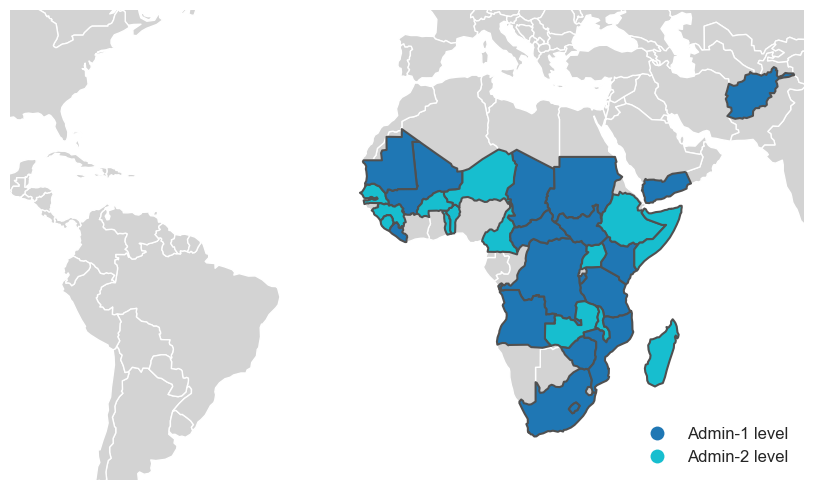

In [12]:
# Little touch on world boundary ---------------------------- #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
world.replace(
    {   'Tanzania':'Tanzania, United Republic of',
        'Dem. Rep. Congo':'DRC',
        'Central African Rep.': 'Central African Republic',
        'S. Sudan':'South Sudan',
    }, inplace=True
)
df = pd.read_csv('../public/hvstat_data.csv', index_col=0, low_memory=False)
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})

# Plotting
mapdata = map_processed.copy().to_crs('epsg:3857')
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis([-10287412, 8589989, -5174166, 6005999])
world.to_crs('epsg:3857').plot(ax=ax, color='lightgrey')
mapdata.plot(ax=ax, column='admin',linewidth=1.5, edgecolor='#505050', zorder=2,
            categorical=True, legend=True,
            legend_kwds={'loc': 'lower right', 'bbox_to_anchor':(1,0), 'frameon':False, 'fontsize':12},
)
plt.tight_layout()
fig.savefig('../docs/current_status_map.svg',pad_inches=0, bbox_inches='tight', transparent=False)

In [15]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,"Tanzania, United Republic of",TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."
176,11062113.0,Africa,South Sudan,SSD,11998,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ..."


In [7]:
country_processed.groupby('admin')['country'].count()
# Group by admin level, and aggregate texts of each country. When grouping, sort countries by alphabet order.
country_list = country_processed.sort_values('country')
country_list = country_list.groupby('admin')['country'].apply(lambda x: ', '.join(x)).reset_index()
for i, row in country_list.iterrows():
    print('Admin', row['admin'], ':', sum(country_processed['admin'] == row['admin']), 'countries')
    print(row['country'])
    print('')

Admin 1 : 18 countries
Afghanistan, Angola, Burundi, Central African Republic, Chad, DRC, Kenya, Lesotho, Liberia, Mali, Mauritania, Mozambique, South Africa, South Sudan, Sudan, Tanzania, United Republic of, Yemen, Zimbabwe

Admin 2 : 14 countries
Benin, Burkina Faso, Cameroon, Ethiopia, Guinea, Madagascar, Malawi, Niger, Senegal, Sierra Leone, Somalia, Togo, Uganda, Zambia

